In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py as h5
import sys
from scipy.stats import binned_statistic
from scipy.stats.mstats import theilslopes
from importlib import reload
from pathlib import Path

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

import ana_fun as ana
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

#matplotlib.rcParams.keys()
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rc('font', size=14)
COLOR = 'grey'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

Loading BokehJS ...

## Import data and plot initial dependencies

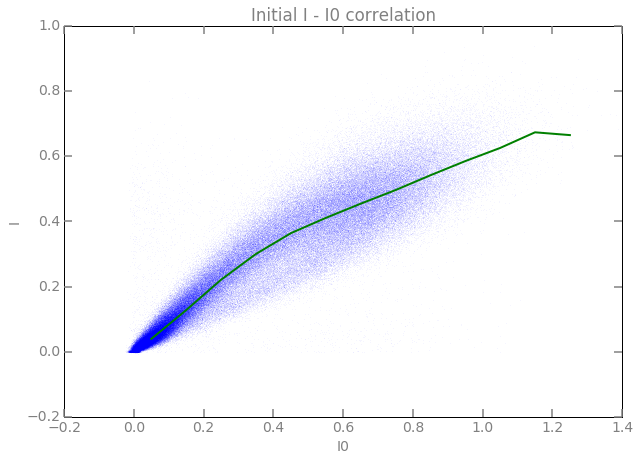

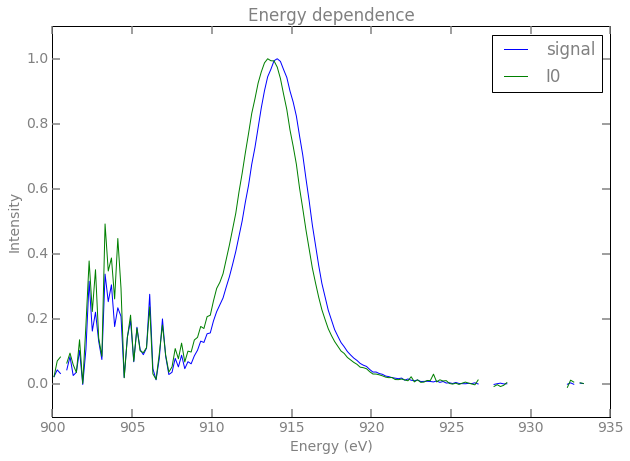

In [2]:
data = datastorage.read('vesp_run60_anaMPI.h5')

mask = np.logical_and(~np.isnan(data.sig), ~np.isnan(data.I0))

dl = data.dl[mask]
I0 = data.I0[mask]*1000
I = data.sig[mask]
energy = data.ebeam.photon_energy[mask]
energyL3 = data.ebeam.L3_energy[mask]

plt.figure('I0 correlation')
plt.title('Initial I - I0 correlation')
plt.plot(I0, I, '.', markersize=0.05)
plt.xlabel('I0')
plt.ylabel('I')

bins = np.arange(0,1.4,0.1)
med = binned_statistic(I0, I, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2)
plt.show()

en_bins = np.arange(900,935,0.2)
xen = en_bins[:-1]+np.diff(en_bins)/2
IvsFEE_average = binned_statistic(energy,I, bins=en_bins, statistic='mean').statistic
I0vsFEE_average = binned_statistic(energy,I0, bins=en_bins, statistic='mean').statistic

plt.figure('Energy')
plt.title('Energy dependence')
plt.plot(xen, IvsFEE_average/np.nanmax(IvsFEE_average), label='signal')
plt.plot(xen, I0vsFEE_average/np.nanmax(I0vsFEE_average), label='I0')
plt.xlabel('Energy (eV)')
plt.ylabel('Intensity')
plt.ylim([-0.1,1.1])
plt.legend()
plt.show()

""" Get timing tool data """
h5path = Path('/reg/d/psdm/SXR/sxri0414/res/automated_analysis_espov/hdf5')
file = 'sxri0414run60.h5'
fh5 = h5.File(h5path / file)


# Linearization

### Linearization: no energy correction

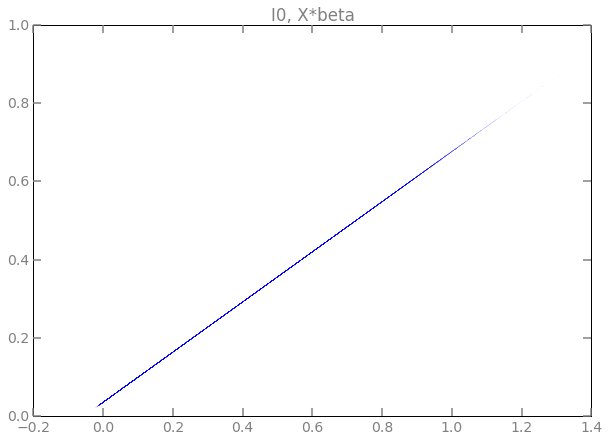

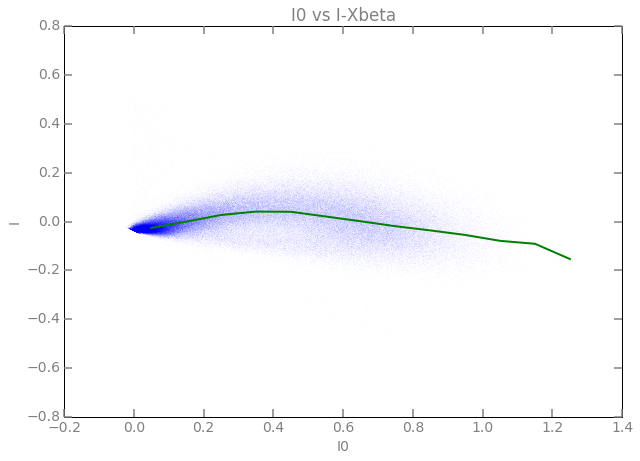

In [3]:
beta, Xbeta = ana.linearize_slope(I,I0)

plt.figure('I0, X*beta')
plt.title('I0, X*beta')
plt.plot(I0,Xbeta,'.',markersize=0.02)

plt.figure('I0 correlation corrected')
plt.plot(I0, I-Xbeta, '.', markersize=0.02)
plt.title('I0 vs I-Xbeta')
plt.xlabel('I0')
plt.ylabel('I')

med = binned_statistic(I0, I-Xbeta, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2)
plt.show()

### Linearization with linear E correction

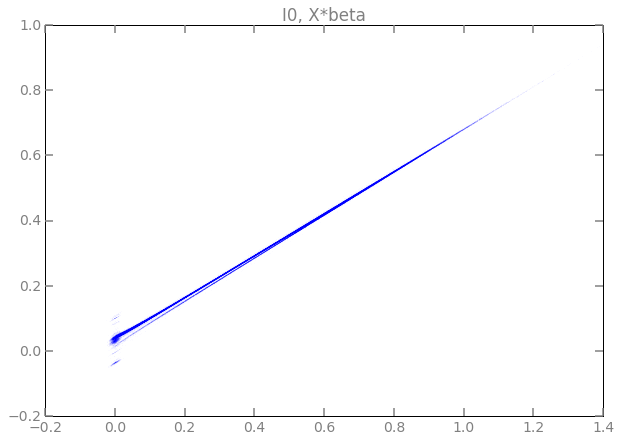

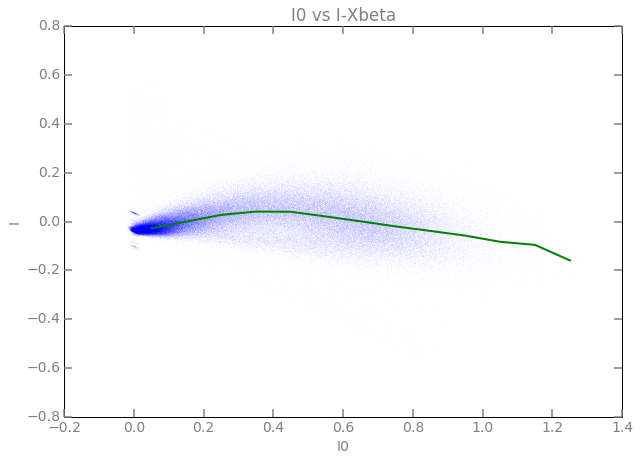

In [4]:
beta, Xbeta = ana.linearize_energy_lin(I,I0,energy)

plt.figure('I0, X*beta')
plt.title('I0, X*beta')
plt.plot(I0,Xbeta,'.',markersize=0.02)

plt.figure('I0 correlation corrected')
plt.plot(I0, I-Xbeta, '.', markersize=0.02)
plt.title('I0 vs I-Xbeta')
plt.xlabel('I0')
plt.ylabel('I')

med = binned_statistic(I0, I-Xbeta, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2)
plt.show()

### Linearization with I0*E correction

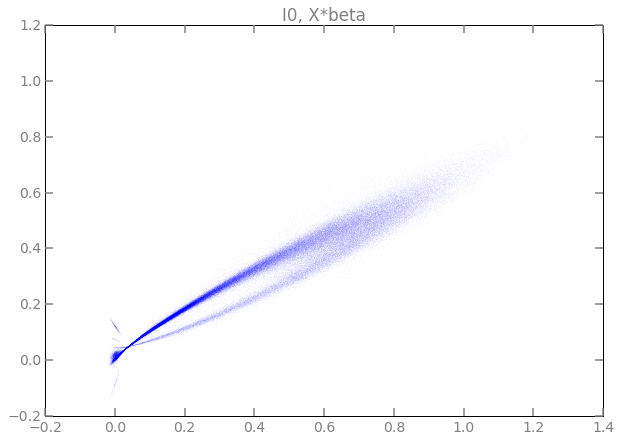

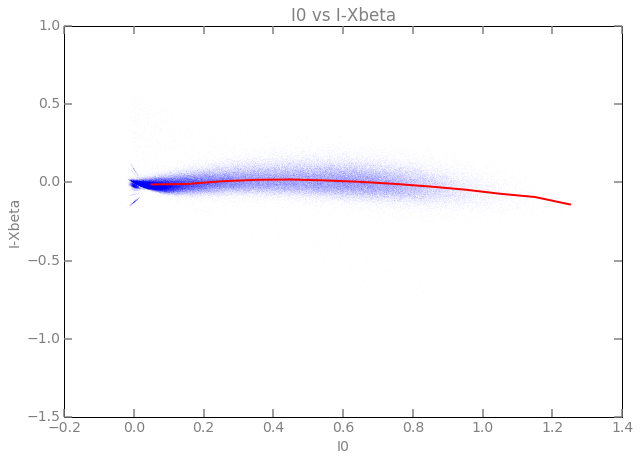

In [5]:
beta, Xbeta = ana.linearize_energy(I,I0,energy)

plt.figure('I0, X*beta')
plt.title('I0, X*beta')
plt.plot(I0,Xbeta,'.',markersize=0.02)

plt.figure('I0 correlation corrected')
plt.plot(I0, I-Xbeta, '.', markersize=0.02)
plt.title('I0 vs I-Xbeta')
plt.xlabel('I0')
plt.ylabel('I-Xbeta')

med = binned_statistic(I0, I-Xbeta, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.figure('I0 correlation corrected')
plt.plot(xmed, med, linewidth=2, color='red')
plt.show()

## Play with OLS

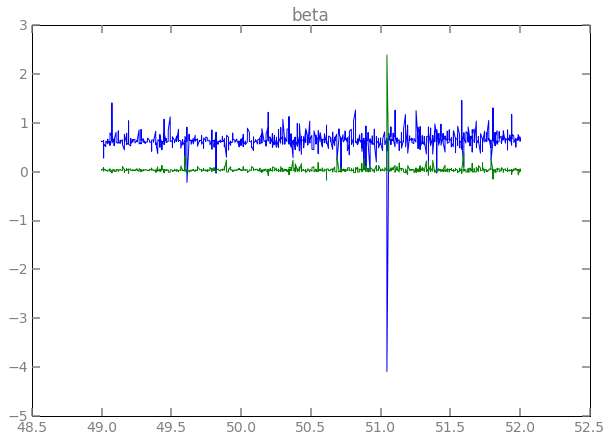

In [6]:
reload(ana)
beta = []
for t in np.unique(dl):
    #print(str(t))
    idx = dl==t
    temp, Xbeta = ana.linearize_slope(I[idx],I0[idx])
    beta.append(temp)

beta = np.asarray(beta)
plt.figure('beta')
plt.title('beta')
plt.plot(np.unique(dl), beta[:,1])
plt.plot(np.unique(dl), beta[:,0])
plt.show()

Little to no offset but the slope alone is not enough to see any pump-probe effect on those data.

### Comparison with theilslopes

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


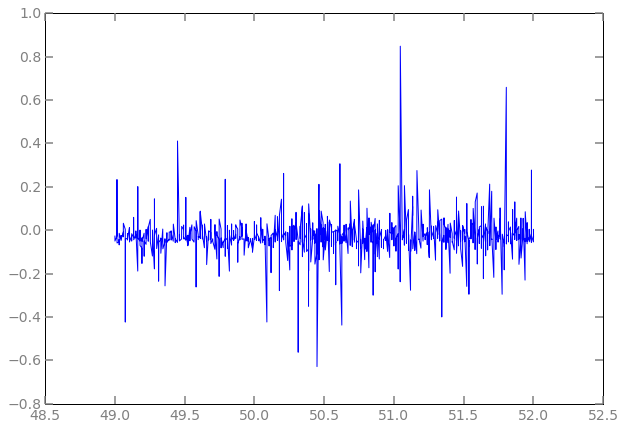

In [7]:
slope = []
for t in np.unique(dl):
    #print(str(t))
    idx = dl==t
    try:
        temp = theilslopes(I[idx],I0[idx])
        slope.append(temp[0])
    except:
        slope.append(np.nan)

slope = np.asarray(slope)
diff = beta[:,1]-slope

p = figure(plot_width=900, plot_height=500)
p.line(np.unique(dl), slope, line_width=2, color='blue', legend='Theil')
p.line(np.unique(dl), beta[:,1], line_width=2, color='red', legend='OLS')
show(p)

plt.figure()
plt.plot(np.unique(dl), diff)
plt.show()

# Pump probe with I0*E correction

In [8]:
beta, Xbeta = ana.linearize_energy(I,I0,energy)
energy_I0_product = (energy-np.mean(energy))*(I0-np.mean(I0))
X = np.array([np.ones(len(I0)), I0, energy, energy_I0_product]).transpose()
I_corr = I - np.matmul(X[:,2:]-np.mean(X,axis=0)[2:], beta[2:])

sig = []
for t in np.unique(dl):
    #print(str(t))
    idx = dl==t
    try:
        temp = theilslopes(I[idx],I0[idx])
        sig.append(temp[0])
    except:
        sig.append(np.nan)

sig = np.asarray(sig)

p = figure(plot_width=900, plot_height=500)
p.line(np.unique(dl), sig, line_width=2)
show(p)

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
